In [ ]:
byimport torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import urllib.request


In [ ]:
MASTER_CONFIG = {
    'batch_size': 32,
    'context_window': 16,
    'd_model': 192,
    'vocab_size': 0,
    'epochs': 1000,
    'log_interval': 10,
    'n_heads': 8,
    'n_layers': 6
}


In [ ]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_name = "tinyshakespeare.txt"
urllib.request.urlretrieve(url, file_name)
lines = open(file_name, 'r').read()
vocab = sorted(list(set(lines)))


In [ ]:
itos = {i: ch for i, ch in enumerate(vocab)}
stoi = {ch: i for i, ch in enumerate(vocab)}

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


In [ ]:
dataset = torch.tensor(encode(lines), dtype=torch.int64)


In [ ]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    batch_data = train if split == 'train' else val if split == 'val' else test
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i + context_window] for i in ix]).long()
    y = torch.stack([batch_data[i + 1:i + context_window + 1] for i in ix]).long()
    return x, y


In [ ]:
MASTER_CONFIG['vocab_size'] = len(vocab)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]
print(decoded_samples)


[('o one sweet bird', ' one sweet bird,'), ('\nLet villany its', 'Let villany itse'), (".'\n\nHERMIONE:\n'T", "'\n\nHERMIONE:\n'Ti"), (' thus bold to pu', 'thus bold to put'), ('raws out our mil', 'aws out our mile'), ('see your wives d', 'ee your wives di'), ('ody with a dange', 'dy with a danger'), ('l go see\nif the ', ' go see\nif the b'), (' hurried the blo', 'hurried the blow'), ('ould not plead, ', 'uld not plead, b'), ('er though not\nth', 'r though not\nthe'), (' and stand aloof', 'and stand aloof:'), (' less expected: ', 'less expected: h'), ("eam'd\nThat any d", "am'd\nThat any di"), ('you do not, make', 'ou do not, make '), ('gested\nAt some t', 'ested\nAt some ti'), ('l he sit under a', ' he sit under a '), ('DWARD IV:\nWhen w', 'WARD IV:\nWhen we'), ('ct, but stand,\nA', 't, but stand,\nAs'), ('heed of yonder d', 'eed of yonder do'), ('yoked with his t', 'oked with his th'), ('le forfeit of un', 'e forfeit of unt'), ('YORK:\nWhat then?', 'ORK:\nWhat then?\n'), (',\nAn out

In [ ]:
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out



In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.scale = nn.Parameter(torch.ones(layer_shape))

    def forward(self, x):
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw


In [ ]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)
        logits = self.linear(x)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits


Model parameters: 65153
Validation loss:  2.4775941371917725


<Axes: >

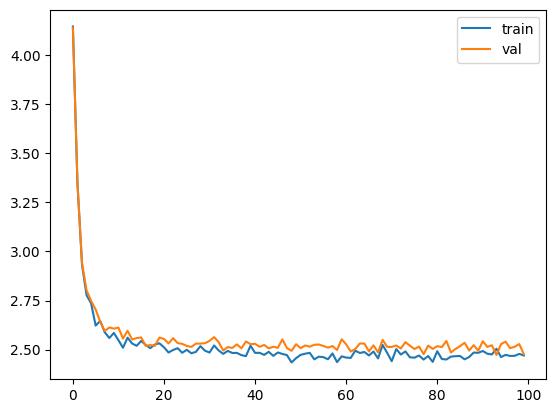

In [ ]:
model = SimpleModel_RMS(MASTER_CONFIG)
optimizer = torch.optim.Adam(model.parameters())

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses.append(x)
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()
            if scheduler:
                print("lr: ", scheduler.get_last_lr())
    print("Validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)


In [ ]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R


In [ ]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)
        activations = F.scaled_dot_product_attention(q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True)
        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


In [ ]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


In [ ]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = nn.Parameter(torch.ones(1))

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out


In [ ]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.layers = nn.Sequential(
            *[nn.Sequential(
                RMSNorm((config['context_window'], config['d_model'])),
                RoPEMaskedMultiheadAttention(config),
                SwiGLU(config['d_model'])
            ) for _ in range(config['n_layers'])]
        )
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.layers(x)
        logits = self.linear(x)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits


Model parameters: 7604231
Validation loss:  3.159560489654541


<Axes: >

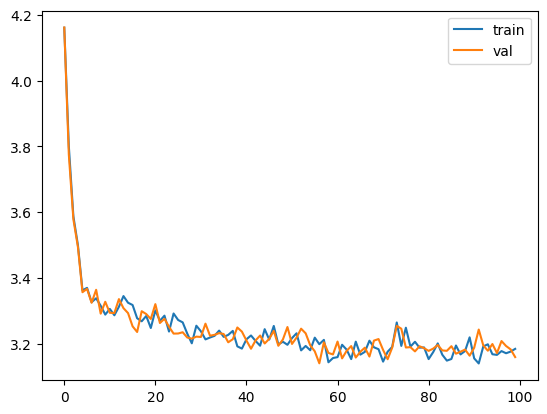

In [ ]:
model = RopeModel(MASTER_CONFIG)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)


In [ ]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()  # Start with 5 sequences of one zero token each
    for _ in range(max_new_tokens):
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[:, -1, :]
        p = F.softmax(last_time_step_logits, dim=-1)
        idx_next = torch.multinomial(p, num_samples=1)
        idx = torch.cat([idx, idx_next], dim=-1)
    return [decode(x) for x in idx.tolist()]

# Generating text
generated_text = generate(model)


In [ ]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)
        x = self.rms(x)
        x = x + self.feedforward(x)
        return x


In [ ]:
from collections import OrderedDict

In [ ]:
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)
        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss


model params: 7900680
Validation loss:  3.1939610481262206
Validation loss:  3.215587306022644


<Axes: >

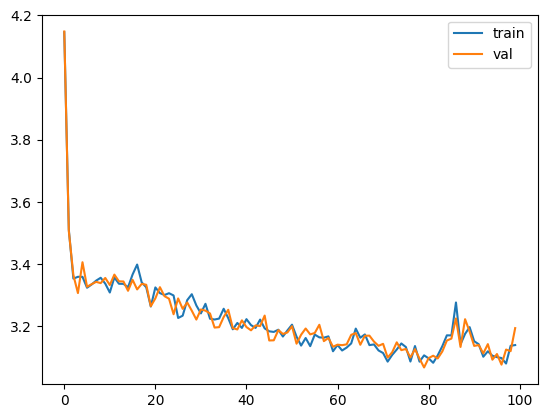

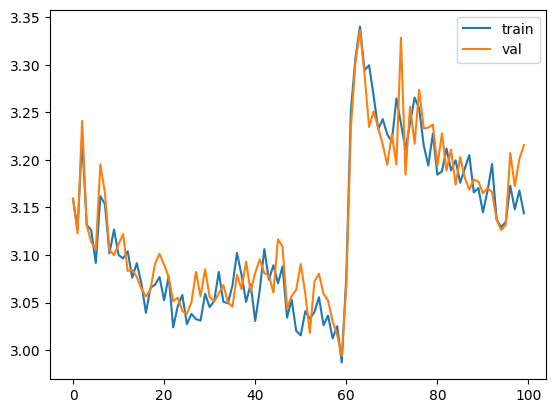

In [ ]:
llama = Llama(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = llama(xs, ys)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer)
train(llama, optimizer, config=MASTER_CONFIG)


In [ ]:
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)


hy eto:c ei:tSm -r;tfcmyrn
Pasdhu e' itee o 'o arkpyt dnBug s  l  ete 
at,i,odho smnoh sri' o mw y.IsuobdeglgyofftZOelhh,Aebdcq tno  h  edint'  ibruedsIroaoicfu ltnams  Kon r stdrhyb ttsh   :ll  
ISaAin oo npvr'a tnnseaey ;rsoro mohINSNascsa B:maezioruaou'oead wlshew  au b:ea euenttkjwottdOei lcwmersta ha hdnteId, etttos oeho eesc,d
WiNla, mh a,na.uo tei mbhp asav Bllogo   ewiInefudleebia cph  c nesspaedai m rrd r ege
ot  E  uIn eheru lol'o;IodiennFaecvnduerilt,,AdiheimtoeC t,l ndeaeaelrt:
T Tfe


In [ ]:
torch.save(llama, 'llama_model.3.pth')
